## Building a QuAM

In [212]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn import linear_model 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# import warnings
# warnings.filterwarnings('ignore')

### Final Dataset Import


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train_X = train.iloc[:,:-1]
train_Y = train.iloc[:,-1]

test_X = test.iloc[:,:-1]
test_Y = test.iloc[:,-1]

In [21]:
def analyze_reg_model(train_Y,test_Y,train_X,test_X, estimator):
    print('Coefficient of determination Training (R2): {:.2f}'.format(r2_score(train_Y, estimator.predict(train_X))))
    print('RMSE Training: {:.2f}\n'.format(mean_squared_error(train_Y, estimator.predict(train_X), squared=False)))
    print('Coefficient of determination Testing (R2): {:.2f}'.format(r2_score(test_Y, estimator.predict(test_X))))
    print('RMSE Testing: {:.2f}\n'.format(mean_squared_error(test_Y, estimator.predict(test_X), squared=False)))
    
    print("Visualizing the Fit")
    plt.scatter(test_Y, estimator.predict(test_X), edgecolors=(0, 0, 0))
    plt.plot(test_Y,test_Y, 'k--', lw=3)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title('RUL: True vs Predicted')
    plt.show()

## Solving the problem of predicting RUL (Regression)

### Iteration 1 (Linear Models)

##### Solution and Justification:
In this approach, we will be trying to use Linear models to predict the RUL. We would be trying to find out if the RUL can be predicted accuratley using a linear combination of the features. I do not know currently if the target can be represented by a linear combination of the features. This experiment is to analyze the effectivness of a linear regressor. 


In [30]:
from sklearn import linear_model 

OLS = linear_model.LinearRegression(fit_intercept=True) 
OLS.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Coefficient of determination Training (R2): 0.65
RMSE Training: 40.83

Coefficient of determination Testing (R2): 0.47
RMSE Testing: 43.03

Visualizing the Fit


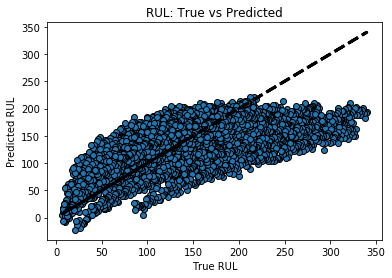

In [31]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, OLS)

In [32]:
## The coefficients
print('Model Coefficients {:.3f} {:.3f} {:.3f}\n'.format(*OLS.coef_))
print('Model Intercept {:.3f}\n'.format(OLS.intercept_))

Model Coefficients -0.416 -12.897 -6.059

Model Intercept 153.030



#### Comment
We observe that the linear model is not able to capture the relationship between the features and the target, Maybe because the relationship cannot be modelled linearly. We would now be trying feature transformatin through kernelization and observing how the results change.

#### Support Vector Machines (With Kernelization)

##### Linear Kernel

In [33]:
clf = svm.SVR(kernel='linear')
clf.fit(train_X, train_Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Coefficient of determination Training (R2): 0.64
RMSE Training: 41.49

Coefficient of determination Testing (R2): 0.42
RMSE Testing: 44.76

Visualizing the Fit


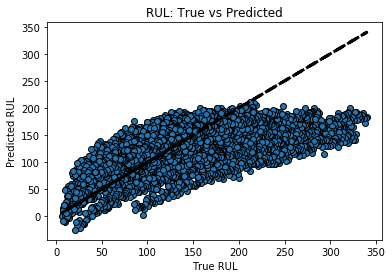

In [34]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, clf)

#### Comment
As expected, this gives us similar performance as linear regression, because we are using a linear kernel

#### RBF Kernel

In [49]:
clf_poly = svm.SVR(C=2, kernel='poly', degree=6)
clf_poly.fit(train_X, train_Y)

SVR(C=2, cache_size=200, coef0=0.0, degree=6, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Coefficient of determination Training (R2): 0.58
RMSE Training: 44.50

Coefficient of determination Testing (R2): 0.33
RMSE Testing: 48.25

Visualizing the Fit


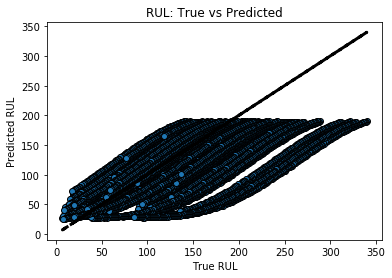

In [50]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, clf_rbf)

##### Solution Details
We first tried to experiment with Ordinary Least Squares regression without regularization. This is because we wanted to compate the effect regularization has on the performance. Then we went on to try regression with SVR, which did regularization with squared l2 penalty. We performed a polynomial kernelization on the features (degree 6), with the regularization parameter C=2. However, we observed that we couldnt get any better results.

##### Lessons Learnt
We see that OLS Linear Regression has performed best in the iteration of Linear Models.

### Final Linear Model (OLS) Visualizatoin and Scores

Coefficient of determination Training (R2): 0.65
RMSE Training: 40.83

Coefficient of determination Testing (R2): 0.47
RMSE Testing: 43.03

Visualizing the Fit


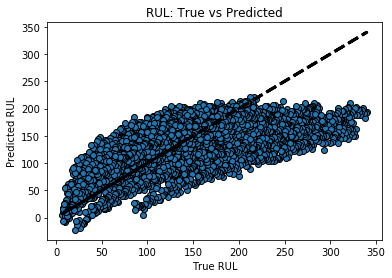

In [51]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, OLS)

### Iteration 2 (Non-Linear Models)

##### Solution and Justification:
In this approach, we will be trying to use Non-Linear models to predict the RUL. 
We would be trying to find out if the RUL can be predicted accuratley using a 
non linear combination of the features. As we saw in the previous iteration, a linear model was not able to fully capture the relationship between 
the features and the target. In this section, we would be two non-linear regressors and comparing their performance.
Specfially KNearestRegressor and DecisionTreeRegressor

#### KNR

In [63]:
def find_best_params_KNR(features, labels, k_values=[2,4,8,16,32,64,128,256,512]):
    
    parameters_grid = {'n_neighbors': k_values }

    estimator = model_selection.GridSearchCV(KNeighborsRegressor(), parameters_grid)
    estimator.fit(features, labels)
    print('Best estimator: {}'.format(estimator.best_estimator_))

    print('\nBest k: {}'.format(estimator.best_params_['n_neighbors']))
    
    return estimator


def find_best_params_DT(features, labels, depth_values=[i for i in range(5,30,2)]):
    
    parameters_grid = {'max_depth': depth_values  }

    estimator = model_selection.GridSearchCV(DecisionTreeRegressor(), parameters_grid)
    estimator.fit(features, labels)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('\nBest depth: {}'.format(estimator.best_params_['max_depth']))
    return estimator

In [56]:
KNN_estimator = find_best_params_KNR(train_X, train_Y)

Best estimator: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=32, p=2,
                    weights='uniform')

Best k: 32


Coefficient of determination Training (R2): 0.71
RMSE Training: 36.79

Coefficient of determination Testing (R2): 0.50
RMSE Testing: 41.53

Visualizing the Fit


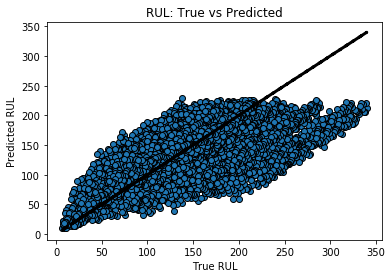

In [57]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, KNN_estimator)

#### Comment
We observer that we have a slight improvement over the OLS Regressor

#### Decision Tree Regressor

In [64]:
DT_Estimator = find_best_params_DT(train_X, train_Y)

Best estimator: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Best depth: 7


Coefficient of determination Training (R2): 0.73
RMSE Training: 36.09

Coefficient of determination Testing (R2): 0.49
RMSE Testing: 41.94

Visualizing the Fit


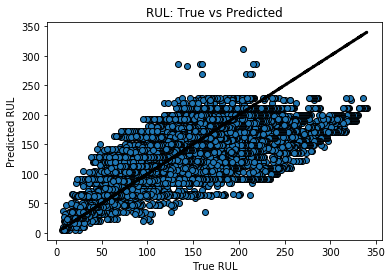

In [65]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, DT_Estimator)

We observe a slight imporovement in training r2, however, the r2 for testing is still almost the same as KNR

##### Solution Details
We first tried to experiment with KNR, we used GridSearchCV to find the best number of neighbors that achieve a balance between fitting the training data and generalizing. We saw that we got an improvement over the Linear Regression model we used in Iteration one. Then we experimented with DTR. In this case we also used GridSearchCV, however we could not get an improvement over the KNR. 

#### Lessons Learnt
Looks like until now, KNR is the best regression model we have to predict RUL values. We learnt that non linear models can better descirbe the relationship between the features and the target.

#### Final Non Linear Model (KNR)

Coefficient of determination Training (R2): 0.71
RMSE Training: 36.79

Coefficient of determination Testing (R2): 0.50
RMSE Testing: 41.53

Visualizing the Fit


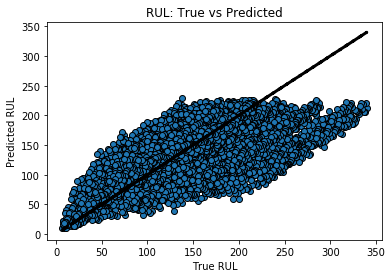

In [67]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, KNN_estimator)

### Iteration 3 (Non-Linear Models (Boosting and Bagging))

##### Solution and Justification:
In this approach, we will be trying to use Bagging and Boosting to see if we can improve the performance of our linear and non-linear regressors through these techniques. For Bagging, I would be experimenting with RandomForestRegressor, and BaggingRegressor with base estimator as KNR. These choices are selected because RFR used decision stumps as its base estimators, and as we saw that they achieve performance similar to KNR, we would like to observe how they perform with Bagging, for BaggingRegressor, we chose KNR as the base model because currently its the best non-linear model that we have. 

For boosting, I would be using AdaBoostRegressot.

### Random Forest Regressor (Bagging)

In [150]:
def find_best_RF_regressor(features, labels, estimators=[j for j in range(50,80,10)], depth=[i for i in range(5,15,2)]):
    
    parameters_grid = {'n_estimators': estimators, "max_depth": depth }
    estimator = model_selection.GridSearchCV(RandomForestRegressor(random_state=99), parameters_grid)
    estimator.fit(features, labels)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('\nBest # of Estimators: {}'.format(estimator.best_params_['n_estimators']))
    print('\nBest # of depth: {}'.format(estimator.best_params_['max_depth']))
    return estimator

In [151]:
estimator_RF = find_best_RF_regressor(train_X, train_Y)

Best estimator: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=99, verbose=0, warm_start=False)

Best # of Estimators: 60

Best # of depth: 7


Coefficient of determination Training (R2): 0.74
RMSE Training: 35.21

Coefficient of determination Testing (R2): 0.52
RMSE Testing: 41.05

Visualizing the Fit


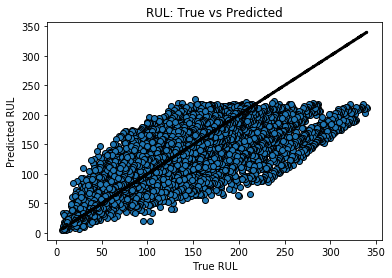

In [152]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, estimator_RF)

#### Comment
We see that we have a new winner. This model is better than the current best model that we have (KNR)

#### Bagging with KNR 

In [193]:
def find_best_BG_regressor(features, labels, estimators=[j for j in range(30,80,10)]):
    
    parameters_grid = {'n_estimators': estimators }
    estimator = model_selection.GridSearchCV(BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=32),random_state=99), parameters_grid)
    estimator.fit(features, labels)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('\nBest # of Estimators: {}'.format(estimator.best_params_['n_estimators']))
    return estimator

In [194]:
best_bgg_reg = find_best_BG_regressor(train_X, train_Y)

Best estimator: BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto',
                                                    leaf_size=30,
                                                    metric='minkowski',
                                                    metric_params=None,
                                                    n_jobs=None, n_neighbors=32,
                                                    p=2, weights='uniform'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=60, n_jobs=None, oob_score=False,
                 random_state=99, verbose=0, warm_start=False)

Best # of Estimators: 60


Coefficient of determination Training (R2): 0.72
RMSE Training: 36.73

Coefficient of determination Testing (R2): 0.51
RMSE Testing: 41.47

Visualizing the Fit


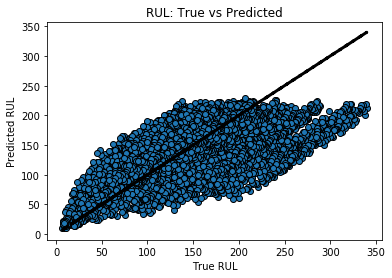

In [195]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, best_bgg_reg)

### AdaBoost Regressor (Boosting)

In [137]:
def find_best_ADB_regressor(features, labels, estimators=[j for j in range(10,100,5)]):
    
    parameters_grid = {'n_estimators': estimators }
    estimator = model_selection.GridSearchCV(AdaBoostRegressor(random_state=99), parameters_grid)
    estimator.fit(features, labels)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('\nBest # of Estimators: {}'.format(estimator.best_params_['n_estimators']))
    return estimator


In [138]:
best_adb_reg = find_best_ADB_regressor(train_X, train_Y)

Best estimator: AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=10, random_state=99)

Best # of Estimators: 10


Coefficient of determination Training (R2): 0.67
RMSE Training: 39.38

Coefficient of determination Testing (R2): 0.47
RMSE Testing: 42.96

Visualizing the Fit


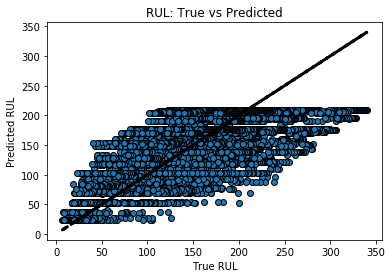

In [139]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, best_adb_reg)

##### Solution Details
We first tried to experiment with RandomForestRegressor, we used GridSearchCV to find the best number of estimators that achieve a balance between fitting the training data and generalizing, and the best max_depth. We saw that we got an improvement over the OLS, and KNR solutions. We then experimented with Bagging. I chose KNR with k=32 as that was the best model we had before RFR. We found the best number of estimators through GridSearchCV, however the model was not an improvement over RFR. Lastly, we experimented with AdaBoost, which was not able to fit the data well.
#### Lessons Learnt
Overall, it seems like RFR is the best regression model we have been able to fit to the data yet, interms of r2 and rmse score. This experiment has helped us finalize the model for regression, in the next steps, we will make a pipeline for it and finalize for deployment

In [196]:
##Importing Unscaled Feature Data

test_unscaled_X = pd.read_csv("test_unscaled.csv")
train_unscaled_X = pd.read_csv("train_unscaled.csv")

In [197]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=99)
ct = ColumnTransformer([
        ('TransformFeatures', StandardScaler(), ['Sensor_11', 'Sensor_9', 'Sensor_12', 'Sensor_4'])
    ], remainder='passthrough')
pipeline = Pipeline(steps=[('t', ct), ('m',model)])

In [198]:
pipeline.fit(train_unscaled_X, train_Y)

Pipeline(memory=None,
         steps=[('t',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('TransformFeatures',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['Sensor_11', 'Sensor_9',
                                                   'Sensor_12', 'Sensor_4'])],
                                   verbose=False)),
                ('m',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=7,
                                       max_features='auto', max_leaf_nodes=None,
       

## Final Regression Pipeline Visualization (RandomForestRegressor)

Coefficient of determination Training (R2): 0.74
RMSE Training: 35.23

Coefficient of determination Testing (R2): 0.52
RMSE Testing: 41.06

Visualizing the Fit


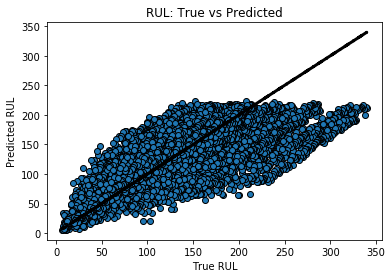

In [199]:
analyze_reg_model(train_Y,test_Y,train_unscaled_X,test_unscaled_X, pipeline)

### Exporting Regression Model

In [201]:
import pickle
with open('regression_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# with open('regression_model.pkl', 'rb') as f:
#     clf = pickle.load(f)

## Bonus: Classification Problem: Predicting Failure "n" days in advance

If the RUL is >20, we would be classifying this engine as "Healthy", and if the RUL is <=20, the engine would be classified as "Needs Maintenence".

In [210]:
def map_rul_to_bin(x):
    if (x > 20):
        return 0 
    else:
        return 1
from sklearn.metrics import confusion_matrix
import seaborn as sns

def show_confusion_matrix(true_labels, learned_labels, class_names):

    cmat = confusion_matrix(true_labels, learned_labels) 

    plt.figure(figsize=(12, 2.5))

    plt.tick_params(labelsize=8)

    
    hm = sns.heatmap(cmat.T, square=True, annot=True, fmt='d', cbar=True,
                     xticklabels=class_names,
                     yticklabels=class_names, 
                     cmap="seismic", 
                     annot_kws={"size":12}, cbar_kws={'label': 'Counts'})

    # this is to set the last axis of the figure, the colorbar in this case
    hm.figure.axes[-1].yaxis.label.set_size(10) # fontsize of bar label
    hm.figure.axes[-1].tick_params(labelsize=8) # fontsize of ticks labels
    
    #plt.ylim(10, 0)

    plt.xlabel('True label', fontsize=9)
    plt.ylabel('Predicted label', fontsize=9)
    
    plt.show()

In [223]:
#Data
train_c_X = train_X
train_c_Y = train_Y.map(map_rul_to_bin)

test_c_X = test_X
test_c_Y = test_Y.map(map_rul_to_bin)

In [213]:
#List of Classifiers that we will try, along with the parameters that we will experiment with
clf = [(KNeighborsClassifier(), {'n_neighbors': [5,10,15]}), (DecisionTreeClassifier(max_depth=10), {'max_depth': [10,15, 20, 25]}),
      (RandomForestClassifier(n_estimators=75), {'max_depth': [10,15, 20, 25]}), (AdaBoostClassifier(n_estimators=100, random_state=0),
                                                                                 {'n_estimators': [75, 100]})]

In [224]:
from sklearn import model_selection as ms

for classifier in clf:
    estimator = ms.GridSearchCV(classifier[0],param_grid=classifier[1])
    estimator.fit(train_c_X, train_c_Y)
    print('Best CV accuracy score: {:.3f}'.format(estimator.best_score_))
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('Best Params: {}'.format(estimator.best_params_))

Best CV accuracy score: 0.955
Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Best Params: {'n_neighbors': 5}
Best CV accuracy score: 0.960
Best estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Best Params: {'max_depth': 10}
Best CV accuracy score: 0.968
Best estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=

#### The best classifer is RandomForestClassifier, with best param being max_depth=10

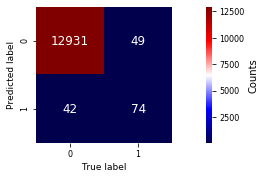

In [225]:
estimator = RandomForestClassifier(max_depth=10)
estimator.fit(train_c_X, train_c_Y)
show_confusion_matrix(test_c_Y, estimator.predict(test_c_X), [0,1])

##### Classification Pipeline


In [226]:
model = RandomForestClassifier(max_depth=10)
ct = ColumnTransformer([
        ('TransformFeatures', StandardScaler(), ['Sensor_11', 'Sensor_9', 'Sensor_12', 'Sensor_4'])
    ], remainder='passthrough')
pipeline = Pipeline(steps=[('t', ct), ('m',model)])

In [227]:
pipeline.fit(train_unscaled_X, train_c_Y)

Pipeline(memory=None,
         steps=[('t',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('TransformFeatures',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['Sensor_11', 'Sensor_9',
                                                   'Sensor_12', 'Sensor_4'])],
                                   verbose=False)),
                ('m',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
    

In [229]:
#show_confusion_matrix(test_c_Y, pipeline.predict(test_unscaled_X), [0,1])

### Exporting Classification Model

In [230]:
import pickle
with open('classification_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# with open('classification_model.pkl', 'rb') as f:
#     clf = pickle.load(f)